In [1]:
versionNumber = 4

In [2]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
import PIL
from PIL import Image
from PIL import ImageFilter,ImageEnhance, ImageOps

Notebooks Parameters

In [4]:
useKaggle = True

performPreprocessing = True

dataAugmentNum = 5
learningRateInit = 0.01

Main paths for images directory

In [5]:
if useKaggle == True:
    inputPath = "/kaggle/input/source/"
    outputPath = "/kaggle/working/cleaned/"
    isExist = os.path.isdir(outputPath)
    if isExist == False:
        os.mkdir(outputPath)
        print("Create output directory")
else:
    inputPath = "./data/source/"
    outputPath = "./data/cleaned/"

Create output directory


In [6]:
#inDir = "selectedTest" # a sample of datas selected
inDir = "selected" # all data selected
outDir = "out" + inDir

### 1. Functions definitions

Parse an image directory and create a dataFrame

In [7]:
# parse image in directory input according to structure of input or output path
# create a datframe with images infos (not with images)
def getImagesDataframe(dirName,inPath):

    df = []
    dirPath = os.path.join(inPath,dirName)
    print("dirPath",dirPath)
    
    if inPath == inputPath :
        for i,breedDir in enumerate(os.listdir(dirPath))  :
            print(i,breedDir)
            num, breed = breedDir.split('-')
            #dogsName.append(breed)
            wList = []
            hList = []
            mList = []
            breedPath = os.path.join(dirPath,breedDir)
            files = glob.glob(breedPath + '/*.jpg')
            for file in files :
                #print("Open ",file)
                img = Image.open(file)
                wList.append(img.width)
                hList.append(img.height)
                mList.append(img.mode)
            df.append(pd.DataFrame({'Name':breed,'Width':wList,'Height':hList,'Mode':mList}))
        dfFull = pd.concat(df,ignore_index=True)
    else:
        files = glob.glob(dirPath + '/*.jpg')
        wList = []
        hList = []
        mList = []
        dogsName = []
        for file in files :
            #print("Open ",file)
            img = Image.open(file)
            # get image number
            imageNum = file.rstrip('.jpg')
            imageNum = (imageNum.removeprefix(dirPath))
            breed,imageNum = imageNum.split('-')
            breed = breed[1:]
            #print(breed,imageNum)
            wList.append(img.width)
            hList.append(img.height)
            mList.append(img.mode)
            dogsName.append(breed)
            dfFull = pd.DataFrame({'Name':dogsName,'Width':wList,'Height':hList,'Mode':mList})
        
    return dfFull

Processing of an image

In [8]:
def processImage(img):
    #print("Enter processImage")

    imgOut = PIL.ImageOps.autocontrast(img,preserve_tone=True)

    return imgOut

Add new images based on the original one

In [9]:
def ImDataAugmentation(img):
    
    #print("Enter ImDataAugmentation ")
    imgList = []
        
    # 1. rotate
    theta = 20
    angle = random.randint(-theta,theta)
    #imgList.append(img.rotate(angle,expand=True))
    imgList.append(img.rotate(angle))
   
    # 2. flip
    imgList.append(img.transpose(Image.FLIP_LEFT_RIGHT))
    
    # 3. gaussian blur
    imgList.append(img.filter(ImageFilter.BLUR))

    # 4. Brightness
    brighAdjust = random.uniform(0.7,1.6)
    enhancer = ImageEnhance.Brightness(img)
    imgList.append(enhancer.enhance(brighAdjust))

    # add some gaussian noise
    noisyImage = Image.effect_noise(img.size, 100)
    noisyImage = noisyImage.convert('RGB')
    imgList.append(Image.blend(img, noisyImage, 0.15))
    
    return imgList


Preprocessing all images from input directory

In [10]:
def convImages(inDir,outDir,resize):
    
    ext = '.jpg'
    print(f"Enter convImages: inDir = {inDir} outDir = {outDir} resize= {resize}")
    # Create outDir if doens't exist
    outDirPath = os.path.join(outputPath, outDir)
    isExist = os.path.isdir(outDirPath)
    if isExist == False:
        os.mkdir(outDirPath)
        print("Creating output directory ",outDirPath)

   
    for i,breedDir in enumerate(os.listdir(inputPath + inDir))  :
        print('Parsing breedDir ', breedDir)
        breedNum, breed = breedDir.split('-')
        breedPath = inputPath + inDir + '/' + breedDir
        #print('breedPath is',breedPath)
        files = glob.glob(breedPath + '/*.jpg')
        for file in files :
            #print("Open ",file)
            img = Image.open(file)
            # get image number
            imageNum = file.rstrip('.jpg')
            imageNum = (imageNum.removeprefix(breedPath))
            temp,imageNum = imageNum.split('_')
            #print('imageNum is ', imageNum)
            
            # preprocessing of the source image
            imgOut = processImage(img)
            
            imgHandles = [imgOut]
            # Perform DataAugmentation() from imgOut
            imgHandles.extend(ImDataAugmentation(imgOut))
            
            # resize all images
            for j,handle in enumerate(imgHandles):
                imgHandles[j] = PIL.ImageOps.fit(handle, resize)
                #PIL.ImageOps.contain(handle, resize)
            
            # create names list for files
            baseName = breed + '-' + imageNum
            outFilename = [baseName + ext if i == 0 else baseName + '_da' + str(i) + ext for i in range(dataAugmentNum+1)]
            
            #print('baseName',baseName)
            
            # store images in outputDir
            for index,fname in enumerate(outFilename):
                #print('index, fullOutFilename',index, fname)
                fullOutFilename =  os.path.join(outDirPath,fname)
                imgHandles[index].save(fullOutFilename)
            
            # Close images files
            for handle in imgHandles:
                handle.close()
            img.close()

Convert one image to format expected for CNN 

In [11]:
# convert image in numpy array of float32 and scale beetween 0 and 1
def convImage(img):
    
    # convert to numpy array
    x = np.array(img)
    # convert to float (64 bits) and scale datas
    x = x / 255.0
    # cast to float32
    x = np.float32(x)
    
    #print(x.shape)
    
    return x

Convert all images from directory to arrays expected for CNN

In [12]:
def genArrays(inDir):
    
    images = []
    labels = []
    
    inPath = os.path.join(outputPath,inDir)
    print("Entering genArrays() with inPath ",inPath)
   
    files = glob.glob(inPath + '/*.jpg')
    for file in files :
        #print("Open ",file)
        img = Image.open(file)
        # get image number
        imageNum = file.rstrip('.jpg')
        imageNum = (imageNum.removeprefix(inPath))
        breed,imageNum = imageNum.split('-')
        breed = breed[1:]
        #print(breed,imageNum)
        
        images.append(convImage(img))
        labels.append(breed)
        
        img.close()
        
    x = np.array(images)
    y = np.array(labels)
    
    return x,y        
    

Function to plot results for loss and accuracy

In [13]:
def plotGraphs(epochs,histObject):
 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle('Transfer Learning Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, histObject.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, histObject.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, 1))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, histObject.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, histObject.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")
    
    plt.show()

### 2. Processing exemple on one image

opening  /kaggle/input/source/selected/n02099601-golden_retriever/n02099601_5.jpg


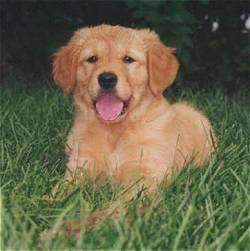

In [14]:
testImgName = inputPath + inDir + "/n02099601-golden_retriever/n02099601_5.jpg"
print("opening ",testImgName)
testImg = Image.open(testImgName)
testImg

Auto tune levels

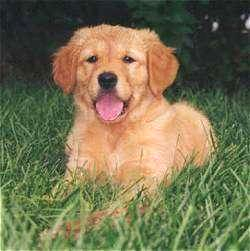

In [15]:
imgOut = processImage(testImg)
imgOut

#### Data Augmentation

In [16]:
a = ImDataAugmentation(imgOut)

Rotate image

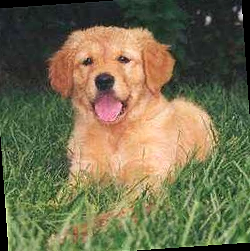

In [17]:
a[0]

Flip image

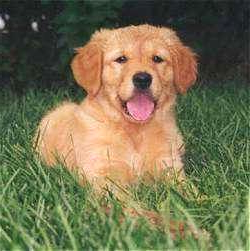

In [18]:
a[1]

Gaussian blur

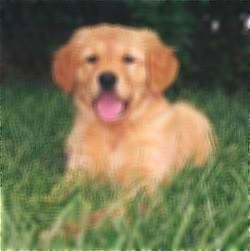

In [19]:
a[2]

Change Brightness

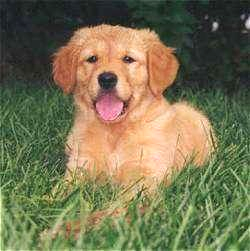

In [20]:
a[3]

Gaussian noise

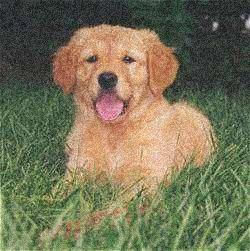

In [21]:
a[4]

### 3. Preprocessing all input images selected

Quick analyse of input datas selected

In [22]:
df = getImagesDataframe(inDir,inputPath)
df.head()

dirPath /kaggle/input/source/selected
0 n02099601-golden_retriever
1 n02107683-Bernese_mountain_dog
2 n02105505-komondor
3 n02110185-Siberian_husky


,Name,Width,Height,Mode
0,golden_retriever,500,333,RGB
1,golden_retriever,360,289,RGB
2,golden_retriever,332,500,RGB
3,golden_retriever,500,375,RGB
4,golden_retriever,175,200,RGB


In [23]:
df.describe()

,Width,Height
count,706.000000,706.000000
mean,457.467422,394.084986
std,161.005853,149.755076
min,160.000000,155.000000
25%,375.000000,333.000000
50%,500.000000,375.000000
75%,500.000000,450.000000
max,2240.000000,2560.000000


In [24]:
df['Name'].value_counts()

Bernese_mountain_dog    216
Siberian_husky          190
komondor                152
golden_retriever        148
Name: Name, dtype: int64

In [25]:
if inDir == "selectedTest":
    resize = (200,200)
elif inDir == "selected":
    resize = (150,150)
else:
    print("WARNING : resize is expected")

if performPreprocessing == True:
    convImages(inDir,outDir, resize=resize)
else:
    print("WARNING : performPreprocessing is set to False")

Enter convImages: inDir = selected outDir = outselected resize= (150, 150)
Creating output directory  /kaggle/working/cleaned/outselected
Parsing breedDir  n02099601-golden_retriever
Parsing breedDir  n02107683-Bernese_mountain_dog
Parsing breedDir  n02105505-komondor
Parsing breedDir  n02110185-Siberian_husky


In [26]:
dfOut = getImagesDataframe(outDir,outputPath)
dfOut.head()

dirPath /kaggle/working/cleaned/outselected


,Name,Width,Height,Mode
0,golden_retriever,150,150,RGB
1,Bernese_mountain_dog,150,150,RGB
2,komondor,150,150,RGB
3,Bernese_mountain_dog,150,150,RGB
4,Siberian_husky,150,150,RGB


In [27]:
dfOut.describe()

,Width,Height
count,4236.0,4236.0
mean,150.0,150.0
std,0.0,0.0
min,150.0,150.0
25%,150.0,150.0
50%,150.0,150.0
75%,150.0,150.0
max,150.0,150.0


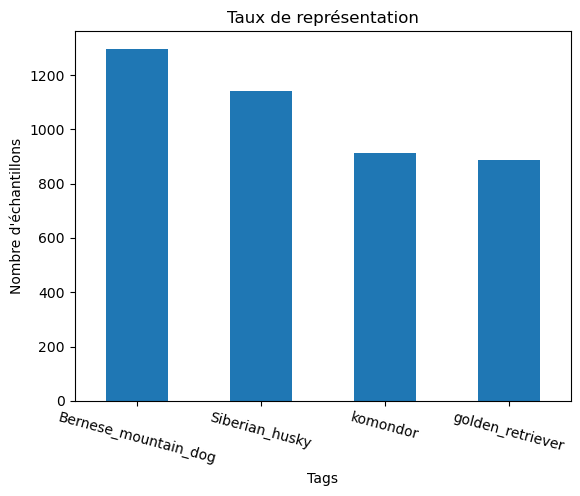

In [28]:
dfOut['Name'].value_counts().plot.bar()
plt.title('Taux de représentation')
plt.xlabel('Tags')
plt.xticks(rotation = -15)
plt.ylabel("Nombre d'échantillons")
plt.show()

In [29]:
dfOut['Name'].value_counts()

Bernese_mountain_dog    1296
Siberian_husky          1140
komondor                 912
golden_retriever         888
Name: Name, dtype: int64

#### Prepare input data for tensorflow

In [30]:
x, y = genArrays(outDir)

Entering genArrays() with inPath  /kaggle/working/cleaned/outselected


In [31]:
print(x.shape)
print(y.shape)

(4236, 150, 150, 3)
(4236,)


In [32]:
print(x.dtype)
print(y.dtype)

float32
<U20


Label encoder on target

In [33]:
le = preprocessing.LabelEncoder()

In [34]:
ytarget = le.fit_transform(y)

Save labels encoder

In [35]:
from joblib import dump, load

In [36]:
labels_filename = 'labelsEncoder.joblib'
dump(le, labels_filename)

['labelsEncoder.joblib']

In [37]:
print(le.classes_)

['Bernese_mountain_dog' 'Siberian_husky' 'golden_retriever' 'komondor']


In [38]:
#yback = le.inverse_transform(ytransf)
#yback

In [39]:
ytarget.shape

(4236,)

Split data (Shuffle included)

In [40]:
xtrain, xval, ytrain, yval = train_test_split(x,ytarget,test_size=0.2,stratify=ytarget,random_state=42)

In [41]:
print(xtrain.shape, ytrain.shape)
print(xval.shape, yval.shape)

(3388, 150, 150, 3) (3388,)
(848, 150, 150, 3) (848,)


### 4. Convolutional Neural Network

In [42]:
modelNames = []
modelLoss = []
modelsAccuracy =[]

a,b = resize
input_size = [a,b,3]

classNumbers = len(le.classes_)
print(f"input_size = {input_size} / output units {classNumbers}")

input_size = [150, 150, 3] / output units 4


In [43]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

# set callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [44]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

First CNN model

In [45]:
model1 = keras.models.Sequential([
DefaultConv2D(filters=64, kernel_size=7, input_shape=input_size),
keras.layers.MaxPooling2D(pool_size=2),
DefaultConv2D(filters=128),
DefaultConv2D(filters=128),
keras.layers.MaxPooling2D(pool_size=2),
DefaultConv2D(filters=256),
DefaultConv2D(filters=256),
keras.layers.MaxPooling2D(pool_size=2),
keras.layers.Flatten(),
keras.layers.Dense(units=128, activation='relu'),
keras.layers.Dropout(0.5),
keras.layers.Dense(units=64, activation='relu'),
keras.layers.Dropout(0.5),
keras.layers.Dense(units=classNumbers, activation='softmax'),
])

In [46]:
optimizer=keras.optimizers.SGD(learning_rate=learningRateInit)

In [47]:
model1.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [48]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 256)       2

In [49]:
epochs = 30
history1 = model1.fit(xtrain, ytrain, epochs=epochs, validation_data=(xval, yval), callbacks=[lr_scheduler,early_stopping_cb])

Epoch 1/30
106/106 [==============================] - 709s 7s/step - loss: 1.3732 - accuracy: 0.3052 - val_loss: 1.3528 - val_accuracy: 0.3290 - lr: 0.0089
Epoch 2/30
106/106 [==============================] - 669s 6s/step - loss: 1.3373 - accuracy: 0.3636 - val_loss: 1.2841 - val_accuracy: 0.4505 - lr: 0.0079
Epoch 3/30
106/106 [==============================] - 669s 6s/step - loss: 1.2853 - accuracy: 0.3985 - val_loss: 1.2374 - val_accuracy: 0.4752 - lr: 0.0071
Epoch 4/30
106/106 [==============================] - 669s 6s/step - loss: 1.2324 - accuracy: 0.4365 - val_loss: 1.1670 - val_accuracy: 0.5200 - lr: 0.0063
Epoch 5/30
106/106 [==============================] - 670s 6s/step - loss: 1.1595 - accuracy: 0.4761 - val_loss: 1.1050 - val_accuracy: 0.5177 - lr: 0.0056
Epoch 6/30
106/106 [==============================] - 668s 6s/step - loss: 1.1019 - accuracy: 0.5183 - val_loss: 0.9972 - val_accuracy: 0.6179 - lr: 0.0050
Epoch 7/30
106/106 [==============================] - 669s 6s/st

pd.DataFrame(history1.history).plot(figsize=(8,5),xlim=[0,29] , xlabel="Epoch")
plt.show()

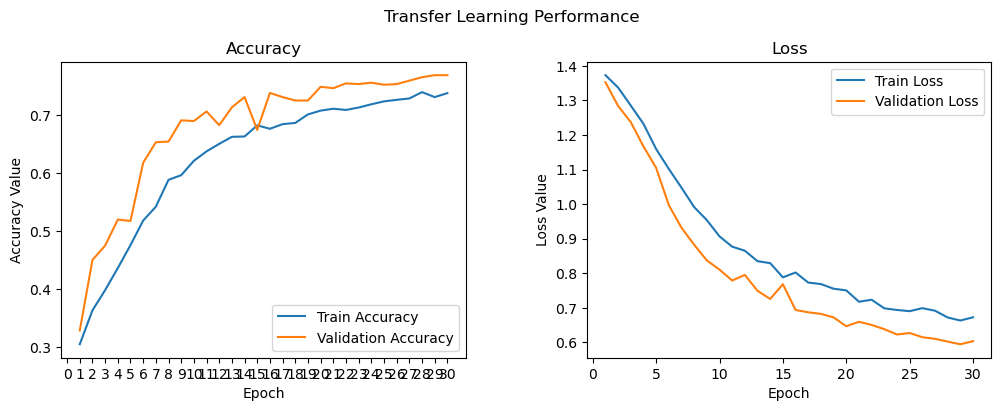

In [50]:
plotGraphs(epochs ,history1)

In [51]:
modelNames.append('CNN Full')
modelLoss.append(history1.history['loss'][-1])
modelsAccuracy.append(history1.history['accuracy'][-1])

a = pd.DataFrame({'Name': modelNames, 'Loss': modelLoss, 'Accuracy': modelsAccuracy })
a.round(3)

,Name,Loss,Accuracy
0,CNN Full,0.672,0.738


Second CNN model

In [52]:
model2 = keras.models.Sequential([
DefaultConv2D(filters=64, kernel_size=7, input_shape=input_size),
keras.layers.MaxPooling2D(pool_size=2),
DefaultConv2D(filters=128),
keras.layers.MaxPooling2D(pool_size=2),
keras.layers.Flatten(),
keras.layers.Dense(units=128, activation='relu'),
keras.layers.Dropout(0.3),
keras.layers.Dense(units=64, activation='relu'),
keras.layers.Dropout(0.3),
keras.layers.Dense(units=classNumbers, activation='softmax'),
])

In [53]:
optimizer=keras.optimizers.SGD(learning_rate=learningRateInit)

In [54]:
model2.compile(loss="sparse_categorical_crossentropy",
optimizer=optimizer,
metrics=["accuracy"])

In [55]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 64)      9472      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 175232)            0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [56]:
epochs = 30
history2 = model2.fit(xtrain, ytrain, epochs=epochs, validation_data=(xval, yval),callbacks=[lr_scheduler,early_stopping_cb])
#history = model.fit(xtrain, ytrain, epochs=10)

Epoch 1/30
106/106 [==============================] - 238s 2s/step - loss: 1.3493 - accuracy: 0.3158 - val_loss: 1.2248 - val_accuracy: 0.5413 - lr: 0.0089
Epoch 2/30
106/106 [==============================] - 234s 2s/step - loss: 1.2366 - accuracy: 0.4501 - val_loss: 1.0878 - val_accuracy: 0.5896 - lr: 0.0079
Epoch 3/30
106/106 [==============================] - 235s 2s/step - loss: 1.1040 - accuracy: 0.5316 - val_loss: 1.0055 - val_accuracy: 0.5896 - lr: 0.0071
Epoch 4/30
106/106 [==============================] - 235s 2s/step - loss: 1.0020 - accuracy: 0.5764 - val_loss: 0.8752 - val_accuracy: 0.6568 - lr: 0.0063
Epoch 5/30
106/106 [==============================] - 235s 2s/step - loss: 0.9380 - accuracy: 0.6068 - val_loss: 0.8525 - val_accuracy: 0.6557 - lr: 0.0056
Epoch 6/30
106/106 [==============================] - 235s 2s/step - loss: 0.8587 - accuracy: 0.6458 - val_loss: 0.7866 - val_accuracy: 0.6781 - lr: 0.0050
Epoch 7/30
106/106 [==============================] - 235s 2s/st

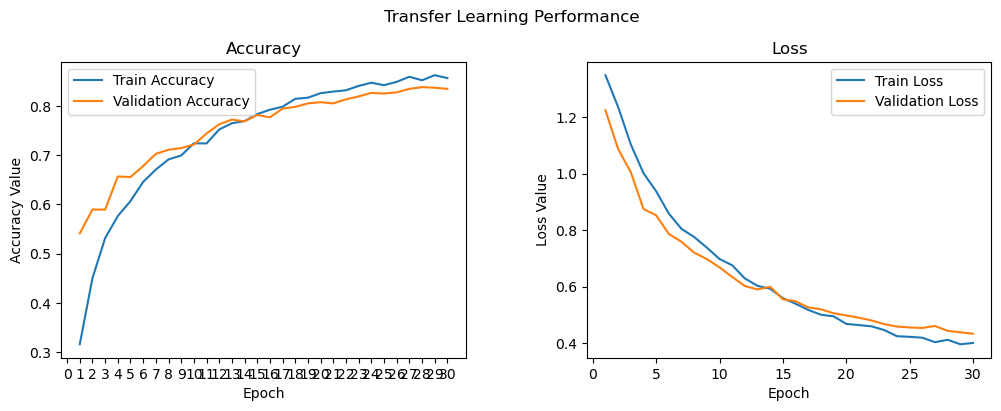

In [57]:
plotGraphs(epochs ,history2)

In [58]:
modelNames.append('CNN Reduct')
modelLoss.append(history2.history['loss'][-1])
modelsAccuracy.append(history2.history['accuracy'][-1])

a = pd.DataFrame({'Name': modelNames, 'Loss': modelLoss, 'Accuracy': modelsAccuracy })
a.round(3)

,Name,Loss,Accuracy
0,CNN Full,0.672,0.738
1,CNN Reduct,0.400,0.857


Transfert Learning model

In [59]:
base_model = keras.applications.resnet50.ResNet50(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(classNumbers, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)
model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                             

In [60]:
train_resized_image = tf.image.resize(xtrain, [224, 224])
train_final_image = keras.applications.resnet50.preprocess_input(train_resized_image * 255)

val_resized_image = tf.image.resize(xval, [224, 224])
val_final_image = keras.applications.resnet50.preprocess_input(val_resized_image * 255)

In [61]:
for layer in base_model.layers:
    layer.trainable = False

In [62]:
optimizer = keras.optimizers.SGD(learning_rate=0.2)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [63]:
epochs = 5
history = model.fit(train_final_image,ytrain, validation_data=(val_final_image, yval), epochs=epochs)

Epoch 1/5
106/106 [==============================] - 412s 4s/step - loss: 0.8540 - accuracy: 0.9622 - val_loss: 0.0192 - val_accuracy: 0.9929
Epoch 2/5
106/106 [==============================] - 425s 4s/step - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0.0252 - val_accuracy: 0.9965
Epoch 3/5
106/106 [==============================] - 428s 4s/step - loss: 0.0010 - accuracy: 0.9994 - val_loss: 0.0054 - val_accuracy: 0.9976
Epoch 4/5
106/106 [==============================] - 409s 4s/step - loss: 2.6033e-05 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9976
Epoch 5/5
106/106 [==============================] - 434s 4s/step - loss: 2.2518e-05 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9976


In [64]:
for layer in base_model.layers:
    layer.trainable = True

In [65]:
epochs = 5
optimizer = keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
historyEnd = model.fit(train_final_image, ytrain, epochs=epochs, validation_data=(val_final_image, yval))

Epoch 1/5
106/106 [==============================] - 1440s 13s/step - loss: 0.0407 - accuracy: 0.9873 - val_loss: 0.0598 - val_accuracy: 0.9858
Epoch 2/5
106/106 [==============================] - 1409s 13s/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 0.0084 - val_accuracy: 0.9965
Epoch 3/5
106/106 [==============================] - 1382s 13s/step - loss: 0.0059 - accuracy: 0.9976 - val_loss: 2.9331e-04 - val_accuracy: 1.0000
Epoch 4/5
106/106 [==============================] - 1386s 13s/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 3.7335e-04 - val_accuracy: 1.0000
Epoch 5/5
106/106 [==============================] - 1373s 13s/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 3.2311e-04 - val_accuracy: 1.0000


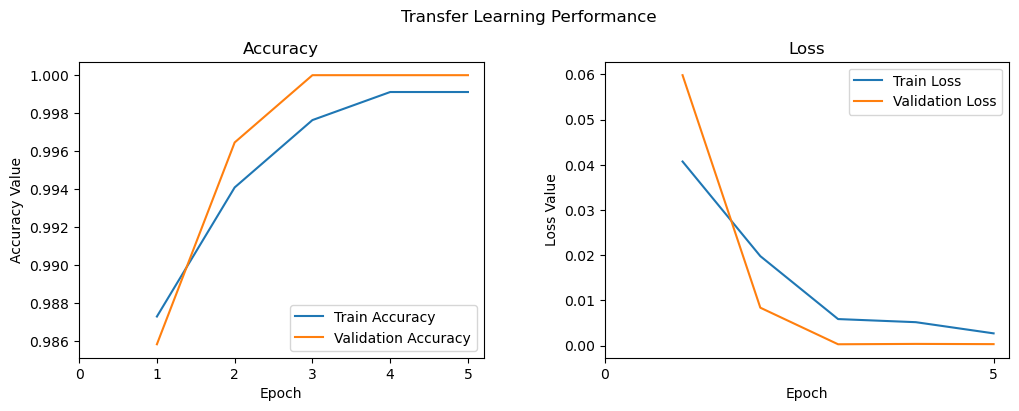

In [66]:
plotGraphs(epochs ,historyEnd)

In [67]:
modelNames.append('CNN resnet50')
modelLoss.append(historyEnd.history['loss'][-1])
modelsAccuracy.append(historyEnd.history['accuracy'][-1])

a = pd.DataFrame({'Name': modelNames, 'Loss': modelLoss, 'Accuracy': modelsAccuracy })
a.round(3)

,Name,Loss,Accuracy
0,CNN Full,0.672,0.738
1,CNN Reduct,0.400,0.857
2,CNN resnet50,0.003,0.999


In [68]:
model.save("my_keras_model.h5")